Redes neurais de classificação geralmente têm uma camada final com uma função sigmoid (para 1 saída) ou softmax (para múltiplas classes). Essa função entrega uma probabilidade entre 0 e 1 para cada classe.

Peça a saída raw da última camada da rede, antes de tomar a decisão.
Essa saída é a probabilidade da classe positiva (euploide).
Multiplique por 100 para transformar em porcentagem.

In [4]:
import pandas as pd
import joblib

# === 1. Carrega a planilha com os dados dos embriões ===
df = pd.read_excel("PlanilhaNumerica.xlsx")

# === 2. Carrega o modelo e o scaler treinados ===
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

# === 3. Prepara os dados ===
X = df.drop(columns=["Ploidia"])  # Remove a resposta real

# Remove a coluna 'Padrão' se existir para evitar erro no scaler
if 'Padrão' in X.columns:
    X = X.drop(columns=['Padrão'])

# Aplica a transformação usando o scaler treinado
X_scaled = scaler.transform(X)

# === 4. Faz a predição da classe (0 ou 1) ===
classes_preditas = modelo.predict(X_scaled)

# === 5. Adiciona ao DataFrame original ===
df["Classe_Prevista"] = classes_preditas

# === 6. Salva em nova planilha ===
df.to_excel("Planilha_Com_Classificacao.xlsx", index=False)

print("✅ Classificações salvas em 'Planilha_Com_Classificacao.xlsx'")

✅ Classificações salvas em 'Planilha_Com_Classificacao.xlsx'


## Pode testar isso aqui com a planilha nova de dados 

## Etapa 1: Lógica da Porcentagem

Vamos usar as variáveis morfocinéticas e morfológicas da planilha. Para cada variável:

- Se o valor do embrião estiver **na faixa favorável**, ele ganha a **pontuação cheia proporcional ao peso** daquela variável.
- Se estiver **fora da faixa favorável**, ganha **zero** (ou um valor intermediário, se quisermos refinar depois com mais precisão ou uma função contínua).

A **soma ponderada dos acertos** (variáveis que estiverem dentro da faixa favorável) dará a **porcentagem estimada de euploidia**, variando de **0 a 100**.

## Etapa 1: Lógica da Porcentagem

Vamos usar as variáveis morfocinéticas e morfológicas da planilha. Para cada variável:

- Se o valor do embrião estiver **na faixa favorável**, ele ganha a **pontuação cheia proporcional ao peso** daquela variável.
- Se estiver **fora da faixa favorável**, ganha **zero** (ou um valor intermediário, se quiser refinar depois com mais precisão ou uma função contínua).

A **soma ponderada dos acertos** (variáveis que estiverem dentro da faixa favorável) dará a **porcentagem estimada de euploidia**, variando de **0 a 100**.

---

## Etapa 2: Pesos Normalizados (baseados na correlação de Spearman ou evidência)

Aqui estão os pesos que usaremos, totalizando 100%:

| Variável     | Peso (%) |
|--------------|----------|
| Idade        | 28.25    |
| t5           | 13.56    |
| tB - tSB     | 15.82    |
| cc3          | 15.82    |
| Estágio      | 10.00    |
| KIDScore     | 10.00    |
| Morfologia   | 10.00    |
| s2           | 5.00     |
| cc2          | 5.00     |
| t5 - t2      | 5.00     |
| **Total**    | **100**  |

# Teste de classificação de ploidia

In [4]:
import pandas as pd
import joblib
import numpy as np

# 1. Carrega os dados
df = pd.read_excel("PlanilhaNumerica.xlsx")

# 2. Carrega o modelo e o scaler treinados
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

# 3. Prepara os dados
X = df.drop(columns=["Ploidia"], errors="ignore")

# 4. Preenche as colunas faltantes com 0 (ex: 'Padrão')
colunas_treinadas = scaler.feature_names_in_
for col in colunas_treinadas:
    if col not in X.columns:
        X[col] = 0  # Ou use np.nan e depois fillna com média, se preferir

# 5. Garante a ordem correta das colunas
X = X[colunas_treinadas]

# 6. Aplica o scaler
X_scaled = scaler.transform(X)

# 7. Faz a predição
classes_preditas = modelo.predict(X_scaled)

# 8. Adiciona ao DataFrame original
df["Classe_Prevista"] = classes_preditas

# 9. Salva planilha com todas as classificações
df.to_excel("Planilha_Com_Classificacao.xlsx", index=False)

# 10. Salva planilha apenas com os embriões euploides
df_euploides = df[df["Classe_Prevista"] == 1]
df_euploides.to_excel("Planilha_Somente_Euploidia.xlsx", index=False)

print("✅ Concluído com sucesso!")
print("📄 Todas as classes: Planilha_Com_Classificacao.xlsx")
print("📄 Somente euploides: Planilha_Somente_Euploidia.xlsx")

✅ Concluído com sucesso!
📄 Todas as classes: Planilha_Com_Classificacao.xlsx
📄 Somente euploides: Planilha_Somente_Euploidia.xlsx


In [18]:
import joblib
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split

# === CARREGAR OS DADOS ===
df_original = pd.read_excel("teste1.xlsx")
X = df_original.drop(columns=["Ploidia"], errors="ignore")
y = df_original["Ploidia"]

# === CARREGAR MODELO E SCALER SALVOS ===
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

# === GARANTIR QUE AS COLUNAS ESTÃO COMPLETAS ===
colunas_treinadas = scaler.feature_names_in_

for col in colunas_treinadas:
    if col not in X.columns:
        X[col] = 0  # ou np.nan e depois preencher com média, se preferir

# === ORDENAR AS COLUNAS NA ORDEM CERTA ===
X = X[colunas_treinadas]

# === DIVIDIR OS DADOS ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# === ESCALAR ===
X_test_scaled = scaler.transform(X_test)

# === FAZER PREVISÕES ===
y_pred = modelo.predict(X_test_scaled)
y_proba = modelo.predict_proba(X_test_scaled)[:, 1]

# === MÉTRICAS ===
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = (tp + tn) / (tp + tn + fp + fn)
recall_1 = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_0 = tn / (tn + fp) if (tn + fp) > 0 else 0
auc = roc_auc_score(y_test, y_proba)

# === EXIBIR RESULTADOS ===
print(f"Acurácia (accuracy): {accuracy:.3f}")
print(f"Recall para Euploide (recall_1): {recall_1:.3f}")
print(f"Recall para Aneuploide (recall_0): {recall_0:.3f}")
print(f"AUC: {auc:.3f}")

Acurácia (accuracy): 1.000
Recall para Euploide (recall_1): 1.000
Recall para Aneuploide (recall_0): 1.000
AUC: 1.000


## parei em:
- fazer ele classificar uma planilha, e retornar uma nova planilha somente com os euploides.
- depois fazer a porcentagem de euploidia somente com essa

## 18/06

Toda rede neural de classificação binária com saída sigmoid já gera essa probabilidade internamente.

Quando você faz:
`modelo.predict_proba(X_scaled)[:, 1]`

* Você já está pegando a chance do embrião ser euploide (classe 1).
* Multiplica isso por 100 e vira uma Porcentagem de Euploidia, que é uma saída contínua, de 0% a 100%.
* Isso é matematicamente correto, estatisticamente interpretável e clinicamente plausível.


=== MÉTRICAS DE DESEMPENHO ===
Acurácia: 0.976
AUC: 0.992
Recall Euploide (Sensibilidade): 0.951
Recall Aneuploide (Especificidade): 1.000

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        41
           1       1.00      0.95      0.97        41

    accuracy                           0.98        82
   macro avg       0.98      0.98      0.98        82
weighted avg       0.98      0.98      0.98        82



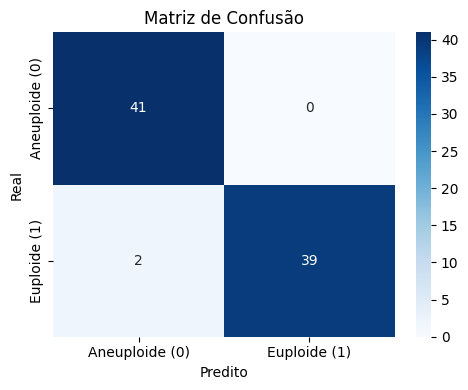

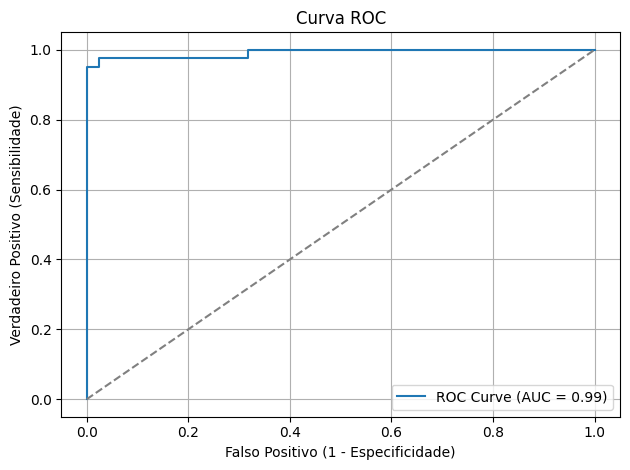


✅ Concluído com sucesso!
📄 Arquivo salvo como: Planilha_Com_Classificacao_e_Porcentagem.xlsx


In [10]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Carrega os dados ===
df = pd.read_excel("PlanilhaNumerica2.xlsx")

# === 2. Carrega o modelo e o scaler treinados ===
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")

# === 3. Prepara os dados ===
X = df.drop(columns=["Ploidia"], errors="ignore")
y_true = df["Ploidia"]

# Verifica e preenche colunas faltantes
colunas_treinadas = scaler.feature_names_in_
for col in colunas_treinadas:
    if col not in X.columns:
        X[col] = 0

# Garante a ordem correta
X = X[colunas_treinadas]

# === 4. Aplica o scaler ===
X_scaled = scaler.transform(X)

# === 5. Faz a classificação binária ===
classes_preditas = modelo.predict(X_scaled)

# === 6. Obtém a probabilidade da classe positiva (euploide) ===
probabilidades = modelo.predict_proba(X_scaled)[:, 1]
porcentagem_euploidia = (probabilidades * 100).round(2)

# === 7. Adiciona as predições ao dataframe ===
df["Classe_Prevista"] = classes_preditas
df["Porcentagem_Euploidia_Preditiva"] = porcentagem_euploidia

# === 8. MÉTRICAS DE DESEMPENHO ===
acc = accuracy_score(y_true, classes_preditas)
auc = roc_auc_score(y_true, probabilidades)

cm = confusion_matrix(y_true, classes_preditas)
tn, fp, fn, tp = cm.ravel()

recall_euploide = tp / (tp + fn) if (tp + fn) > 0 else 0
recall_aneuploide = tn / (tn + fp) if (tn + fp) > 0 else 0

print("\n=== MÉTRICAS DE DESEMPENHO ===")
print(f"Acurácia: {acc:.3f}")
print(f"AUC: {auc:.3f}")
print(f"Recall Euploide (Sensibilidade): {recall_euploide:.3f}")
print(f"Recall Aneuploide (Especificidade): {recall_aneuploide:.3f}")

print("\n=== Classification Report ===")
print(classification_report(y_true, classes_preditas))

# === 9. Matriz de Confusão ===
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Aneuploide (0)", "Euploide (1)"],
            yticklabels=["Aneuploide (0)", "Euploide (1)"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()

# === 10. Curva ROC ===
fpr, tpr, thresholds = roc_curve(y_true, probabilidades)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo (1 - Especificidade)")
plt.ylabel("Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === 11. Salva a planilha final com tudo ===
df.to_excel("Planilha_Com_Classificacao_e_Porcentagem.xlsx", index=False)

print("\n✅ Concluído com sucesso!")
print("📄 Arquivo salvo como: Planilha_Com_Classificacao_e_Porcentagem.xlsx")

In [5]:
import joblib

scaler = joblib.load("scaler_mlp_20250610_113659.pkl")
print(type(scaler))

<class 'sklearn.preprocessing._data.StandardScaler'>


In [13]:
import joblib
import numpy as np

# Carregar scaler e modelo
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")

print("\n=== INFORMAÇÕES DO SCALER ===")
print("Features usadas no scaler:")
print(scaler.feature_names_in_)

print("\nMédia por feature (mean_):")
print(scaler.mean_)

print("\nDesvio padrão por feature (scale_):")
print(scaler.scale_)

print("\n=== INFORMAÇÕES DO MODELO ===")
try:
    print("Classes do modelo:")
    print(modelo.classes_)
except AttributeError:
    print("O modelo não possui o atributo 'classes_' (pode não ser classificador)")

print("\nParâmetros do modelo:")
print(modelo.get_params())

# Se for uma rede neural do scikit-learn (MLPClassifier), pode mostrar os pesos
if hasattr(modelo, 'coefs_'):
    print("\nForma dos pesos da primeira camada:")
    print(np.array(modelo.coefs_[0]).shape)


=== INFORMAÇÕES DO SCALER ===
Features usadas no scaler:
['Idade' 'Estágio' 'Morfo' 'Kidscore' 't2' 't3' 't4' 't5' 't8' 'tSC' 'tSB'
 'tB' 'cc2 (t3-t2)' 'cc3 (t5-t3)' 't5-t2' 's2 (t4-t3)' 's3 (t8-t5)'
 'tSC-t8' 'tB-tSB']

Média por feature (mean_):
[ 39.33596772   5.16902568   2.65042186   5.76758788  24.8914474
  36.10126391  37.23971247  46.78520555  54.75299744  88.53379375
 101.53538679 110.19603865  10.48254885  11.62423426  22.13161514
   1.45177237   8.21358128  33.1960585    9.14902193]

Desvio padrão por feature (scale_):
[ 3.09787881  0.39953588  1.00752792  2.11588986  2.49325165  3.64435754
  3.07891458  6.24962942  6.75702743 10.19747205  9.02884956 11.29670871
  2.55763402  4.08892192  5.26392192  1.91065511  5.84387745 10.60409035
  4.01136389]

=== INFORMAÇÕES DO MODELO ===
Classes do modelo:
[0 1]

Parâmetros do modelo:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_

c:\Users\maria.ferreira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


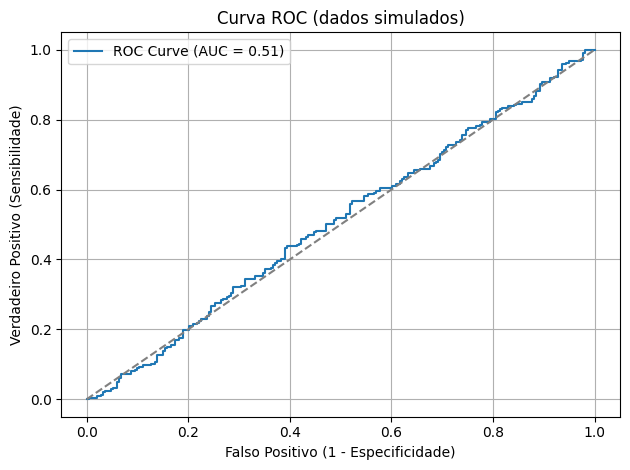


AUC nos dados simulados: 0.507


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import joblib

# Carregar scaler e modelo
scaler = joblib.load("scaler_mlp_20250610_113659.pkl")
modelo = joblib.load("melhor_modelo_mlp_20250610_113659.pkl")

# Número de features que o scaler espera
n_features = len(scaler.feature_names_in_)

# Simulando 500 exemplos aleatórios com as mesmas dimensões
np.random.seed(42)
X_fake = np.random.normal(size=(500, n_features))

# Aplicar o scaler nos dados falsos
X_scaled = scaler.transform(X_fake)

# Simulando y_true com classes 0 e 1 aleatórias
y_true = np.random.randint(0, 2, size=500)

# Gerar probabilidades
prob_raw = modelo.predict_proba(X_scaled)[:, 1]

# Calcular AUC
auc = roc_auc_score(y_true, prob_raw)

# Gerar curva ROC
fpr, tpr, thresholds = roc_curve(y_true, prob_raw)

# Plotar
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Falso Positivo (1 - Especificidade)")
plt.ylabel("Verdadeiro Positivo (Sensibilidade)")
plt.title("Curva ROC (dados simulados)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nAUC nos dados simulados: {auc:.3f}")
